In [8]:
import torchvision
import torch
from torch.utils.data import Subset
import torchvision.transforms.functional as F

transform=torchvision.transforms.Compose([ 
    torchvision.transforms.Lambda(lambda img: F.crop(img, top=2, left=2, height=img.height - 4, width=img.width - 4)),
    torchvision.transforms.Resize((20, 20), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda tensor: (tensor * 10).float())
])

train_dataset = torchvision.datasets.MNIST("data/mnist", download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.MNIST("data/mnist", download=True, train=False, transform=transform)

train_subset = Subset(train_dataset, range(60000))  
test_subset = Subset(train_dataset, range(10000))  
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=2048, shuffle=False)

In [2]:
G_MAX_P = [45.553, 48.860, 48.911]
G_MAX_D = [20.145, 44.382, 44.382]
G_MIN_P = [1.515,  2.442,  2.317]
G_MIN_D = [1.761,  8.274,  8.374]
AP =  [0.673,  0.204,  0.018] # concern
AD =  [0.107,  0.032,  0.032]
BP =  [-0.597, -0.329, 0.496] # concern
BD =  [3.649,  5.839,  5.839]

In [9]:
import torch 
import torch.nn as nn 

start_p = 15 * 10**-9 # Start at around 15nS
start_d = 15 * 10**-9 
def mysign(x): return (x > 0).float()


def count_sign_difference(tensor1, tensor2):
    # Compute sign of each tensor (-1 for negative, 0 for zero, 1 for positive)
    sign1 = torch.sign(tensor1)
    sign2 = torch.sign(tensor2)
    # Count where the signs differ
    num_different = torch.sum(sign1 != sign2).item()
    return num_different

class MnistClassifier(nn.Module):
    def __init__(self, hidden_dim): 
        super(MnistClassifier, self).__init__()
        self.in_dim = 400
        self.hidden_dim = hidden_dim
        self.out_dim = 10
        
        self.flat = nn.Flatten()
        self.Ron = 5 * (10 ** 6)
        self.act = nn.Sigmoid()

        self.alpha_P = 0 
        self.alpha_D = 0 
        self.beta_P = 0 
        self.beta_D = 0 
        self.G_max_p = 0 
        self.G_min_p = 0 
        self.G_max_d = 0 
        self.G_min_d = 0 

        self.update_setup(0)

        self.g_plus_1  = nn.Parameter( torch.rand((self.in_dim,self.hidden_dim ))*(10**-9) + start_p)
        self.g_minus_1 = nn.Parameter(-torch.rand((self.in_dim,self.hidden_dim ))*(10**-9) + start_d)
        self.g_plus_2  = nn.Parameter( torch.rand((self.hidden_dim,self.out_dim))*(10**-9) + start_p)
        self.g_minus_2 = nn.Parameter(-torch.rand((self.hidden_dim,self.out_dim))*(10**-9) + start_d)


    def function_P(self, x): return self.alpha_P * torch.exp(-1*self.beta_P*((x-self.G_min_p)/(self.G_max_p-self.G_min_p)))
    def function_D(self, x): return self.alpha_D * torch.exp(-1*self.beta_D*((self.G_max_d-x)/(self.G_max_d-self.G_min_d)))
    def compute_gradient_P(self, params, deltas): return mysign(deltas) * self.function_P(params)
    def compute_gradient_D(self, params, deltas): return mysign(-deltas) * self.function_D(params)




    
    # CHANGES THE GRANULARITY
    def update_setup(self, I):
        self.G_max_p = G_MAX_P[I] * (10 ** -9)
        self.G_max_d = G_MAX_D[I] * (10 ** -9) 
        self.G_min_p = G_MIN_P[I] * (10 ** -9)
        self.G_min_d = G_MIN_D[I] * (10 ** -9)
        self.alpha_P = AP[I] 
        self.beta_P  = BP[I] 
        self.alpha_D = AD[I] 
        self.beta_D  = BD[I] 
            



    
    # SHIFTS THE PLUS AND MINUS WEIGHTS TO ALLOW FOR MORE CHANGES IN LIGHT OF CLIPPING
    def refresh_func(self, plus_tensor, minus_tensor): 
        clipped_count = 0
        W = (plus_tensor - minus_tensor).clone()
        
        # FOR CORRECTING G_PLUS BEING MAXIMUM 
        mask = (plus_tensor  > self.G_max_p * torch.ones_like(plus_tensor)).int()
        inv_mask = 1 - mask
        with torch.no_grad():
            new_minus = minus_tensor * inv_mask + self.G_min_d * mask
            new_plus = plus_tensor * inv_mask + (W + self.G_min_d) * mask            
            minus_tensor.copy_(new_minus)
            plus_tensor.copy_(new_plus)
        
        # FOR CORRECTING G_MINUS BEING MAXIMUM 
        mask = (minus_tensor > self.G_max_d * torch.ones_like(minus_tensor)).int()
        inv_mask = 1 - mask
        with torch.no_grad():
            new_plus = plus_tensor * inv_mask + self.G_min_p * mask     
            new_minus = minus_tensor * inv_mask + (-W + self.G_min_p) * mask     
            minus_tensor.copy_(new_minus)
            plus_tensor.copy_(new_plus)

        return W 
    




    # SHIFTS WEIGHTS AND CLIP 
    def refresh(self): 
        W1_before = self.refresh_func(self.g_plus_1, self.g_minus_1)
        W2_before = self.refresh_func(self.g_plus_2, self.g_minus_2)

        err1 = torch.norm((self.g_plus_1 - self.g_minus_1) - W1_before).item()
        err2 = torch.norm((self.g_plus_2 - self.g_minus_2) - W2_before).item()
        error = err1 + err2 
        
        with torch.no_grad():  
            self.g_plus_1.data.clamp_( self.G_min_p, self.G_max_p)
            self.g_minus_1.data.clamp_(self.G_min_d, self.G_max_d)
            self.g_plus_2.data.clamp_( self.G_min_p, self.G_max_p)
            self.g_minus_2.data.clamp_(self.G_min_d, self.G_max_d)

        clipped_count = 0 
        mask = torch.isclose(self.g_plus_1,  self.G_max_p * torch.ones_like(self.g_plus_1), atol=1e-15).int()
        clipped_count += torch.sum(mask).item()
        mask = torch.isclose(self.g_minus_1, self.G_max_d * torch.ones_like(self.g_minus_1),  atol=1e-15).int()
        clipped_count += torch.sum(mask).item()
        mask = torch.isclose(self.g_plus_2,  self.G_max_p * torch.ones_like(self.g_plus_2), atol=1e-15).int()
        clipped_count += torch.sum(mask).item()
        mask = torch.isclose(self.g_minus_2, self.G_max_d * torch.ones_like(self.g_minus_2),  atol=1e-15).int()
        clipped_count += torch.sum(mask).item()

        return clipped_count, error





    # FORWARD PROPAGATION 
    def forward(self, x): 
        x = self.flat(x)
        self.W_1 = self.g_plus_1 - self.g_minus_1
        if(torch.is_grad_enabled()): self.W_1.retain_grad()
        self.h_1 = torch.matmul(x,self.W_1)
        self.y_1 = self.h_1 * self.Ron 

        self.y_1 = self.act(self.y_1)
        self.W_2 = self.g_plus_2 - self.g_minus_2
        if(torch.is_grad_enabled()): self.W_2.retain_grad()
        self.h_2 = torch.matmul(self.y_1,self.W_2)
        self.y_2 = self.h_2 * self.Ron 
        return self.y_2
    



    
    # ANALOG UPDATE RULE 
    def update_parameters(self): 
        measurement1, measurement2, measurement3, measurement4 = 0,0,0,0
        # UPDATE CACLULATION 
        with torch.no_grad():
            ##############################################################################################################
            target_updates1 = -0.05 * self.W_1.grad * torch.norm(self.W_1) / (torch.norm(self.W_1.grad) + 10**-20)

            # INCREASING PULSE COUNT FOR D1
            target_updates_D1 = -1 * (target_updates1 < 0).int() * target_updates1 
            pseudo_updates_D1 = self.compute_gradient_D(self.g_minus_1.data, target_updates1) * (10 ** -9)
            self.g_minus_1 += target_updates_D1  
    
            # INCREASING PULSE COUNT FOR P1
            target_updates_P1 = (target_updates1 > 0).int() * target_updates1 
            pseudo_updates_P1 = self.compute_gradient_P(self.g_plus_1.data, target_updates1) * (10 ** -9)
            self.g_plus_1 += target_updates_P1
            ##############################################################################################################
            measurement1 = torch.norm(target_updates_P1).item()
            measurement2 = torch.norm(pseudo_updates_P1).item()
            measurement3 = torch.norm(self.g_plus_1).item()
            
            ##############################################################################################################
            target_updates2 = -0.05 * self.W_2.grad * torch.norm(self.W_2) / (torch.norm(self.W_2.grad) + 10**-20)

            # INCREASING PULSE COUNT FOR D1
            target_updates_D2 = -1 *(target_updates2 < 0).int() * target_updates2 
            pseudo_updates_D2 = self.compute_gradient_D(self.g_minus_2.data, target_updates2) * (10 ** -9)
            self.g_minus_2 +=  target_updates_D2

            # INCREASING PULSE COUNT FOR P1
            target_updates_P2 = (target_updates2 > 0).int() * target_updates2 
            pseudo_updates_P2 = self.compute_gradient_P(self.g_plus_2.data, target_updates2) * (10 ** -9)
            self.g_plus_2 +=  target_updates_P2
            ##############################################################################################################
            measurement4 = count_sign_difference(target_updates_P1, pseudo_updates_P1) + count_sign_difference(target_updates_D1, pseudo_updates_D1) + count_sign_difference(target_updates_P2, pseudo_updates_P2) + count_sign_difference(target_updates_D2, pseudo_updates_D2) 

        clipped, error = self.refresh()
        return measurement1, measurement2, measurement3, measurement4, clipped, error 
    

In [13]:
from tqdm import tqdm 

device = torch.device("cuda")
model = MnistClassifier(50)
model = model.to(device)
model.update_setup(2)
model.refresh()

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters())
losses, accuracies = [], []
MEASUREMENT1, MEASUREMENT2, MEASUREMENT3, MEASUREMENT4 = [],[],[],[]
CLIPPED, ERROR = [], []

# BASELINE ACCURACY EVALUATION
total_correct = 0
total_predictions = 0 
model.eval()
with torch.no_grad():
    for test_imgs, test_labels in test_loader: 
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_preds = model(test_imgs)
        predicted = torch.argmax(test_preds, dim=1)
        total_correct += (predicted == test_labels).sum().item()
        total_predictions += test_labels.size(0)
accuracy = total_correct / total_predictions
accuracies.append(accuracy)
model.train()  # Back to training mode


# TRAINING LOOP 
num_epochs = 60
num_batches = len(train_loader)
eval_interval = max(1, num_batches // 3)  # Check every 1/10th of an epoch
for epoch in range(num_epochs):
    
    # if(epoch == 1): model.update_setup(0)
    # model.refresh()
        
    total_loss = 0 
    for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader)):
    # for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)

        labels = 5 * torch.nn.functional.one_hot(labels, num_classes=10).float()
        loss = criterion(preds, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        measurement1, measurement2, measurement3, measurement4, clipped, error = model.update_parameters()
        MEASUREMENT1.append(measurement1), MEASUREMENT2.append(measurement2), MEASUREMENT3.append(measurement3), MEASUREMENT4.append(measurement4)
        CLIPPED.append(clipped), ERROR.append(error)

        # Every 1/10th of an epoch, evaluate accuracy
        if (batch_idx + 1) % eval_interval == 0:
            total_correct = 0
            total_predictions = 0 
            model.eval()
            with torch.no_grad():
                for test_imgs, test_labels in test_loader: 
                    test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
                    test_preds = model(test_imgs)
                    predicted = torch.argmax(test_preds, dim=1)
                    total_correct += (predicted == test_labels).sum().item()
                    total_predictions += test_labels.size(0)
            accuracy = total_correct / total_predictions
            accuracies.append(accuracy)
            model.train()  # Back to training mode
        losses.append(loss.item())
            
    print(f"Epoch {epoch}, Loss: {total_loss}, Accuracy: {accuracy}, {accuracies[-10:]}") 
    # losses.append(total_loss)


100%|██████████| 938/938 [00:16<00:00, 56.62it/s]


Epoch 0, Loss: 1641.7644293904305, Accuracy: 0.8201, [0.0978, 0.5397, 0.8227, 0.8201]


100%|██████████| 938/938 [00:17<00:00, 54.67it/s]


Epoch 1, Loss: 918.2925696074963, Accuracy: 0.8649, [0.0978, 0.5397, 0.8227, 0.8201, 0.8727, 0.89, 0.8649]


100%|██████████| 938/938 [00:16<00:00, 56.09it/s]


Epoch 2, Loss: 771.3070734739304, Accuracy: 0.8677, [0.0978, 0.5397, 0.8227, 0.8201, 0.8727, 0.89, 0.8649, 0.8902, 0.8853, 0.8677]


100%|██████████| 938/938 [00:16<00:00, 55.80it/s]


Epoch 3, Loss: 763.4355739355087, Accuracy: 0.8733, [0.8201, 0.8727, 0.89, 0.8649, 0.8902, 0.8853, 0.8677, 0.8916, 0.8887, 0.8733]


100%|██████████| 938/938 [00:16<00:00, 56.17it/s]


Epoch 4, Loss: 758.5299437940121, Accuracy: 0.8681, [0.8649, 0.8902, 0.8853, 0.8677, 0.8916, 0.8887, 0.8733, 0.8858, 0.8888, 0.8681]


100%|██████████| 938/938 [00:16<00:00, 55.58it/s]


Epoch 5, Loss: 756.0478109717369, Accuracy: 0.8767, [0.8677, 0.8916, 0.8887, 0.8733, 0.8858, 0.8888, 0.8681, 0.8867, 0.8897, 0.8767]


100%|██████████| 938/938 [00:16<00:00, 55.97it/s]


Epoch 6, Loss: 755.0592067539692, Accuracy: 0.8681, [0.8733, 0.8858, 0.8888, 0.8681, 0.8867, 0.8897, 0.8767, 0.8895, 0.8907, 0.8681]


100%|██████████| 938/938 [00:16<00:00, 56.14it/s]


Epoch 7, Loss: 755.4267097115517, Accuracy: 0.8624, [0.8681, 0.8867, 0.8897, 0.8767, 0.8895, 0.8907, 0.8681, 0.8782, 0.8882, 0.8624]


100%|██████████| 938/938 [00:17<00:00, 55.10it/s]


Epoch 8, Loss: 756.3618802428246, Accuracy: 0.8592, [0.8767, 0.8895, 0.8907, 0.8681, 0.8782, 0.8882, 0.8624, 0.8753, 0.8814, 0.8592]


100%|██████████| 938/938 [00:16<00:00, 56.06it/s]


Epoch 9, Loss: 752.7962258756161, Accuracy: 0.8709, [0.8681, 0.8782, 0.8882, 0.8624, 0.8753, 0.8814, 0.8592, 0.8914, 0.8877, 0.8709]


100%|██████████| 938/938 [00:16<00:00, 55.79it/s]


Epoch 10, Loss: 747.300754070282, Accuracy: 0.8628, [0.8624, 0.8753, 0.8814, 0.8592, 0.8914, 0.8877, 0.8709, 0.8828, 0.8794, 0.8628]


100%|██████████| 938/938 [00:16<00:00, 55.81it/s]


Epoch 11, Loss: 747.6688794791698, Accuracy: 0.8692, [0.8592, 0.8914, 0.8877, 0.8709, 0.8828, 0.8794, 0.8628, 0.877, 0.8889, 0.8692]


100%|██████████| 938/938 [00:17<00:00, 55.00it/s]


Epoch 12, Loss: 744.9975809156895, Accuracy: 0.8639, [0.8709, 0.8828, 0.8794, 0.8628, 0.877, 0.8889, 0.8692, 0.8825, 0.892, 0.8639]


100%|██████████| 938/938 [00:16<00:00, 56.11it/s]


Epoch 13, Loss: 745.7542257010937, Accuracy: 0.8719, [0.8628, 0.877, 0.8889, 0.8692, 0.8825, 0.892, 0.8639, 0.8793, 0.8824, 0.8719]


100%|██████████| 938/938 [00:17<00:00, 55.16it/s]


Epoch 14, Loss: 745.5367649197578, Accuracy: 0.8703, [0.8692, 0.8825, 0.892, 0.8639, 0.8793, 0.8824, 0.8719, 0.8855, 0.8937, 0.8703]


100%|██████████| 938/938 [00:17<00:00, 54.32it/s]


Epoch 15, Loss: 745.459641367197, Accuracy: 0.8668, [0.8639, 0.8793, 0.8824, 0.8719, 0.8855, 0.8937, 0.8703, 0.882, 0.8851, 0.8668]


100%|██████████| 938/938 [00:17<00:00, 55.11it/s]


Epoch 16, Loss: 745.5247502923012, Accuracy: 0.8619, [0.8719, 0.8855, 0.8937, 0.8703, 0.882, 0.8851, 0.8668, 0.8844, 0.8886, 0.8619]


100%|██████████| 938/938 [00:16<00:00, 55.47it/s]


Epoch 17, Loss: 744.7465936541557, Accuracy: 0.8512, [0.8703, 0.882, 0.8851, 0.8668, 0.8844, 0.8886, 0.8619, 0.8814, 0.8931, 0.8512]


100%|██████████| 938/938 [00:16<00:00, 55.58it/s]


Epoch 18, Loss: 745.5029312372208, Accuracy: 0.864, [0.8668, 0.8844, 0.8886, 0.8619, 0.8814, 0.8931, 0.8512, 0.8902, 0.8911, 0.864]


100%|██████████| 938/938 [00:17<00:00, 54.79it/s]


Epoch 19, Loss: 746.0512734353542, Accuracy: 0.8668, [0.8619, 0.8814, 0.8931, 0.8512, 0.8902, 0.8911, 0.864, 0.8877, 0.8947, 0.8668]


100%|██████████| 938/938 [00:17<00:00, 54.98it/s]


Epoch 20, Loss: 744.2069099843502, Accuracy: 0.8535, [0.8512, 0.8902, 0.8911, 0.864, 0.8877, 0.8947, 0.8668, 0.8886, 0.8899, 0.8535]


100%|██████████| 938/938 [00:16<00:00, 55.47it/s]


Epoch 21, Loss: 737.4225286543369, Accuracy: 0.8705, [0.864, 0.8877, 0.8947, 0.8668, 0.8886, 0.8899, 0.8535, 0.889, 0.8943, 0.8705]


100%|██████████| 938/938 [00:16<00:00, 55.25it/s]


Epoch 22, Loss: 739.2514187991619, Accuracy: 0.8693, [0.8668, 0.8886, 0.8899, 0.8535, 0.889, 0.8943, 0.8705, 0.8862, 0.8901, 0.8693]


100%|██████████| 938/938 [00:17<00:00, 54.74it/s]


Epoch 23, Loss: 738.6230490207672, Accuracy: 0.8622, [0.8535, 0.889, 0.8943, 0.8705, 0.8862, 0.8901, 0.8693, 0.8898, 0.8912, 0.8622]


100%|██████████| 938/938 [00:16<00:00, 55.34it/s]


Epoch 24, Loss: 738.299692094326, Accuracy: 0.8586, [0.8705, 0.8862, 0.8901, 0.8693, 0.8898, 0.8912, 0.8622, 0.8873, 0.8924, 0.8586]


100%|██████████| 938/938 [00:17<00:00, 54.96it/s]


Epoch 25, Loss: 739.2700698375702, Accuracy: 0.8637, [0.8693, 0.8898, 0.8912, 0.8622, 0.8873, 0.8924, 0.8586, 0.8928, 0.8908, 0.8637]


100%|██████████| 938/938 [00:16<00:00, 55.22it/s]


Epoch 26, Loss: 740.324267745018, Accuracy: 0.8618, [0.8622, 0.8873, 0.8924, 0.8586, 0.8928, 0.8908, 0.8637, 0.8854, 0.8775, 0.8618]


100%|██████████| 938/938 [00:17<00:00, 54.34it/s]


Epoch 27, Loss: 737.706999629736, Accuracy: 0.8518, [0.8586, 0.8928, 0.8908, 0.8637, 0.8854, 0.8775, 0.8618, 0.8826, 0.8846, 0.8518]


100%|██████████| 938/938 [00:17<00:00, 54.13it/s]


Epoch 28, Loss: 743.8386096358299, Accuracy: 0.8758, [0.8637, 0.8854, 0.8775, 0.8618, 0.8826, 0.8846, 0.8518, 0.8884, 0.89, 0.8758]


100%|██████████| 938/938 [00:17<00:00, 53.40it/s]


Epoch 29, Loss: 741.6226875185966, Accuracy: 0.87, [0.8618, 0.8826, 0.8846, 0.8518, 0.8884, 0.89, 0.8758, 0.8884, 0.8866, 0.87]


100%|██████████| 938/938 [00:17<00:00, 53.08it/s]


Epoch 30, Loss: 733.0592612326145, Accuracy: 0.859, [0.8518, 0.8884, 0.89, 0.8758, 0.8884, 0.8866, 0.87, 0.881, 0.8888, 0.859]


100%|██████████| 938/938 [00:17<00:00, 53.57it/s]


Epoch 31, Loss: 732.4565028548241, Accuracy: 0.8695, [0.8758, 0.8884, 0.8866, 0.87, 0.881, 0.8888, 0.859, 0.8764, 0.8903, 0.8695]


100%|██████████| 938/938 [00:17<00:00, 54.02it/s]


Epoch 32, Loss: 728.9016089439392, Accuracy: 0.8714, [0.87, 0.881, 0.8888, 0.859, 0.8764, 0.8903, 0.8695, 0.8813, 0.8926, 0.8714]


100%|██████████| 938/938 [00:17<00:00, 53.53it/s]


Epoch 33, Loss: 724.7165601551533, Accuracy: 0.8751, [0.859, 0.8764, 0.8903, 0.8695, 0.8813, 0.8926, 0.8714, 0.8895, 0.89, 0.8751]


100%|██████████| 938/938 [00:17<00:00, 53.43it/s]


Epoch 34, Loss: 727.1904503107071, Accuracy: 0.8792, [0.8695, 0.8813, 0.8926, 0.8714, 0.8895, 0.89, 0.8751, 0.8887, 0.8881, 0.8792]


100%|██████████| 938/938 [00:17<00:00, 54.31it/s]


Epoch 35, Loss: 724.1111105084419, Accuracy: 0.8766, [0.8714, 0.8895, 0.89, 0.8751, 0.8887, 0.8881, 0.8792, 0.8817, 0.8936, 0.8766]


100%|██████████| 938/938 [00:17<00:00, 54.12it/s]


Epoch 36, Loss: 721.5459134876728, Accuracy: 0.8706, [0.8751, 0.8887, 0.8881, 0.8792, 0.8817, 0.8936, 0.8766, 0.8828, 0.8835, 0.8706]


100%|██████████| 938/938 [00:16<00:00, 55.22it/s]


Epoch 37, Loss: 722.7070206403732, Accuracy: 0.8753, [0.8792, 0.8817, 0.8936, 0.8766, 0.8828, 0.8835, 0.8706, 0.8853, 0.8982, 0.8753]


100%|██████████| 938/938 [00:17<00:00, 52.20it/s]


Epoch 38, Loss: 723.2567365169525, Accuracy: 0.8865, [0.8766, 0.8828, 0.8835, 0.8706, 0.8853, 0.8982, 0.8753, 0.8934, 0.8983, 0.8865]


100%|██████████| 938/938 [00:17<00:00, 53.99it/s]


Epoch 39, Loss: 723.3755437135696, Accuracy: 0.8704, [0.8706, 0.8853, 0.8982, 0.8753, 0.8934, 0.8983, 0.8865, 0.8861, 0.884, 0.8704]


100%|██████████| 938/938 [00:17<00:00, 54.01it/s]


Epoch 40, Loss: 720.0682457089424, Accuracy: 0.8836, [0.8753, 0.8934, 0.8983, 0.8865, 0.8861, 0.884, 0.8704, 0.8899, 0.8904, 0.8836]


100%|██████████| 938/938 [00:17<00:00, 54.33it/s]


Epoch 41, Loss: 721.7613095343113, Accuracy: 0.8669, [0.8865, 0.8861, 0.884, 0.8704, 0.8899, 0.8904, 0.8836, 0.8895, 0.888, 0.8669]


100%|██████████| 938/938 [00:17<00:00, 52.73it/s]


Epoch 42, Loss: 722.2155020534992, Accuracy: 0.8639, [0.8704, 0.8899, 0.8904, 0.8836, 0.8895, 0.888, 0.8669, 0.8934, 0.8943, 0.8639]


100%|██████████| 938/938 [00:17<00:00, 52.75it/s]


Epoch 43, Loss: 722.6521221101284, Accuracy: 0.8581, [0.8836, 0.8895, 0.888, 0.8669, 0.8934, 0.8943, 0.8639, 0.8861, 0.881, 0.8581]


100%|██████████| 938/938 [00:17<00:00, 52.92it/s]


Epoch 44, Loss: 721.4499835371971, Accuracy: 0.8791, [0.8669, 0.8934, 0.8943, 0.8639, 0.8861, 0.881, 0.8581, 0.8803, 0.8884, 0.8791]


100%|██████████| 938/938 [00:17<00:00, 52.35it/s]


Epoch 45, Loss: 722.0933166146278, Accuracy: 0.8693, [0.8639, 0.8861, 0.881, 0.8581, 0.8803, 0.8884, 0.8791, 0.8885, 0.887, 0.8693]


100%|██████████| 938/938 [00:17<00:00, 52.74it/s]


Epoch 46, Loss: 723.2732412815094, Accuracy: 0.8726, [0.8581, 0.8803, 0.8884, 0.8791, 0.8885, 0.887, 0.8693, 0.8814, 0.891, 0.8726]


100%|██████████| 938/938 [00:17<00:00, 52.45it/s]


Epoch 47, Loss: 721.3547339141369, Accuracy: 0.8672, [0.8791, 0.8885, 0.887, 0.8693, 0.8814, 0.891, 0.8726, 0.8864, 0.8798, 0.8672]


100%|██████████| 938/938 [00:17<00:00, 52.66it/s]


Epoch 48, Loss: 722.1439156532288, Accuracy: 0.8729, [0.8693, 0.8814, 0.891, 0.8726, 0.8864, 0.8798, 0.8672, 0.8967, 0.8756, 0.8729]


100%|██████████| 938/938 [00:18<00:00, 52.03it/s]


Epoch 49, Loss: 712.6233723163605, Accuracy: 0.8689, [0.8726, 0.8864, 0.8798, 0.8672, 0.8967, 0.8756, 0.8729, 0.878, 0.8945, 0.8689]


100%|██████████| 938/938 [00:17<00:00, 52.74it/s]


Epoch 50, Loss: 713.6863107979298, Accuracy: 0.8652, [0.8672, 0.8967, 0.8756, 0.8729, 0.878, 0.8945, 0.8689, 0.8862, 0.883, 0.8652]


100%|██████████| 938/938 [00:17<00:00, 52.72it/s]


Epoch 51, Loss: 713.2186770737171, Accuracy: 0.8695, [0.8729, 0.878, 0.8945, 0.8689, 0.8862, 0.883, 0.8652, 0.8873, 0.8942, 0.8695]


100%|██████████| 938/938 [00:17<00:00, 52.51it/s]


Epoch 52, Loss: 714.1264212429523, Accuracy: 0.8686, [0.8689, 0.8862, 0.883, 0.8652, 0.8873, 0.8942, 0.8695, 0.8814, 0.885, 0.8686]


 40%|███▉      | 373/938 [00:06<00:10, 54.07it/s]


KeyboardInterrupt: 

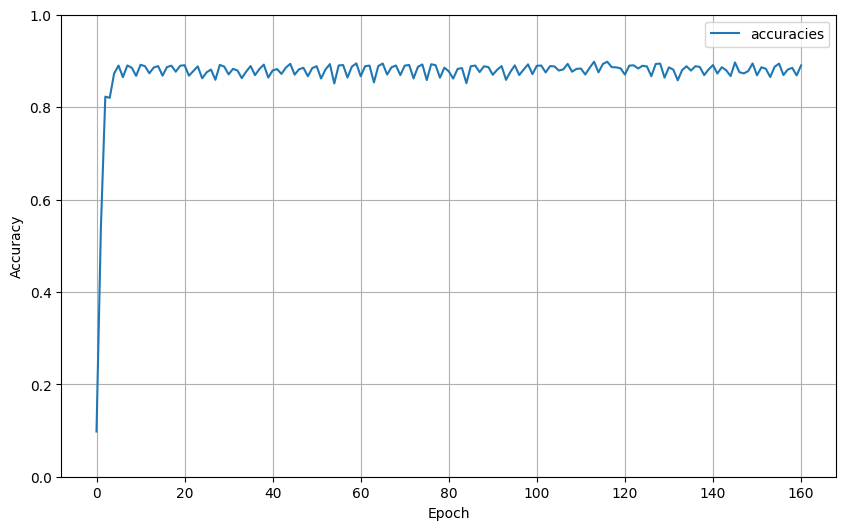

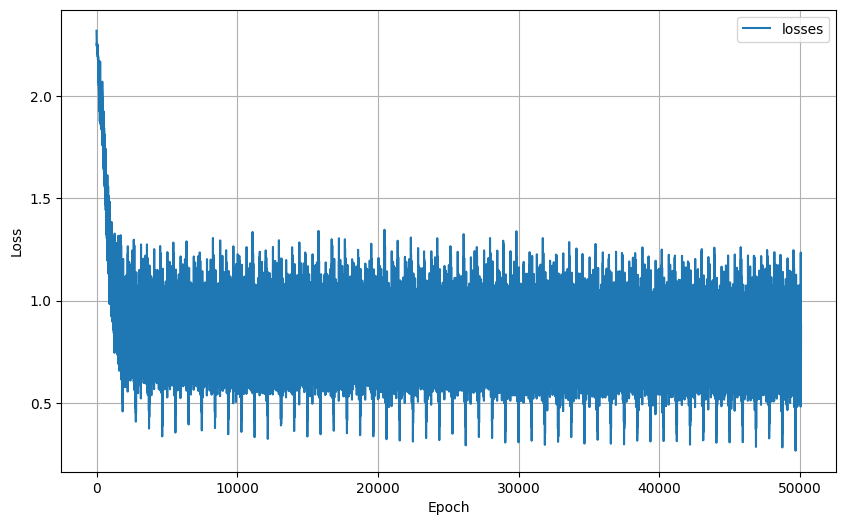

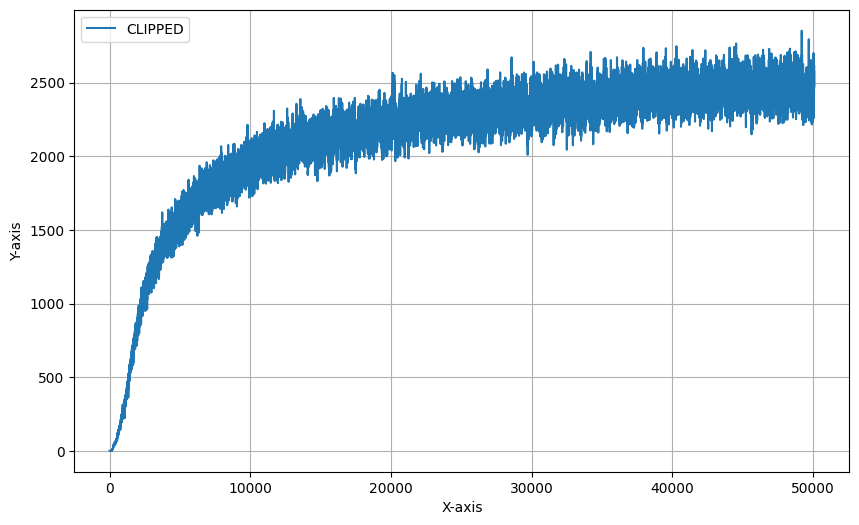

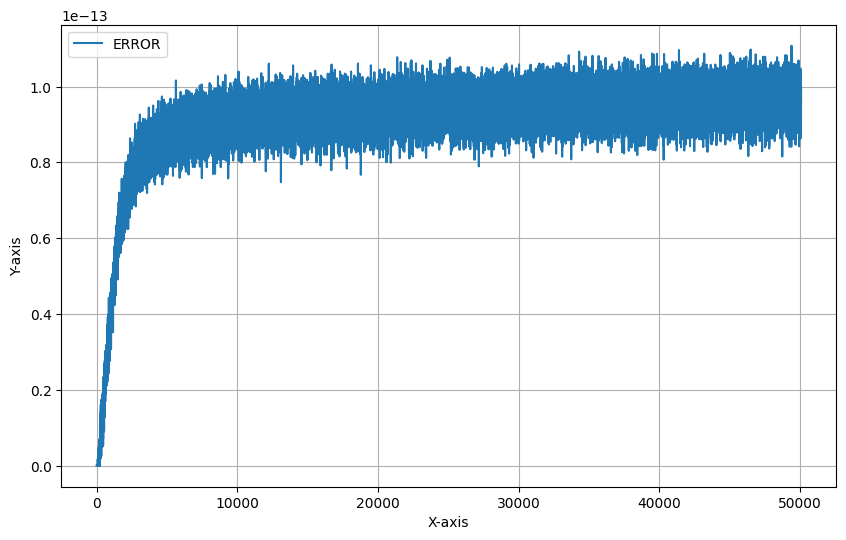

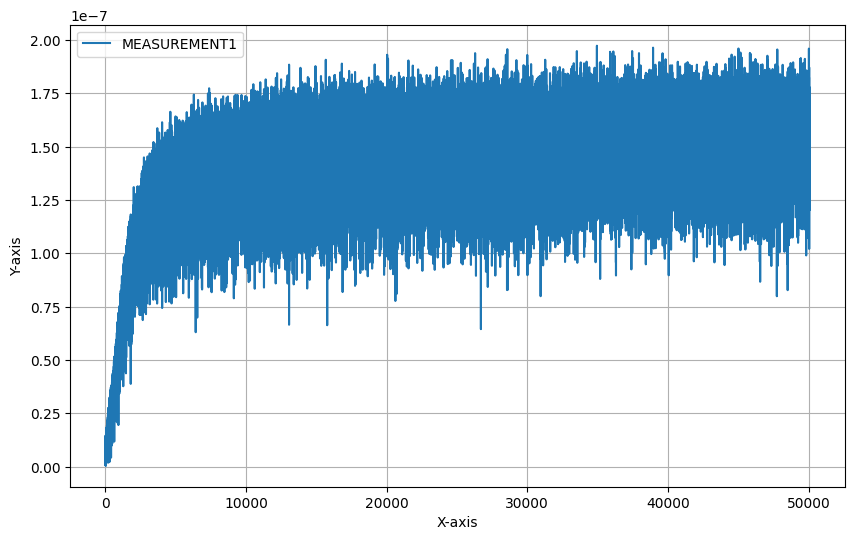

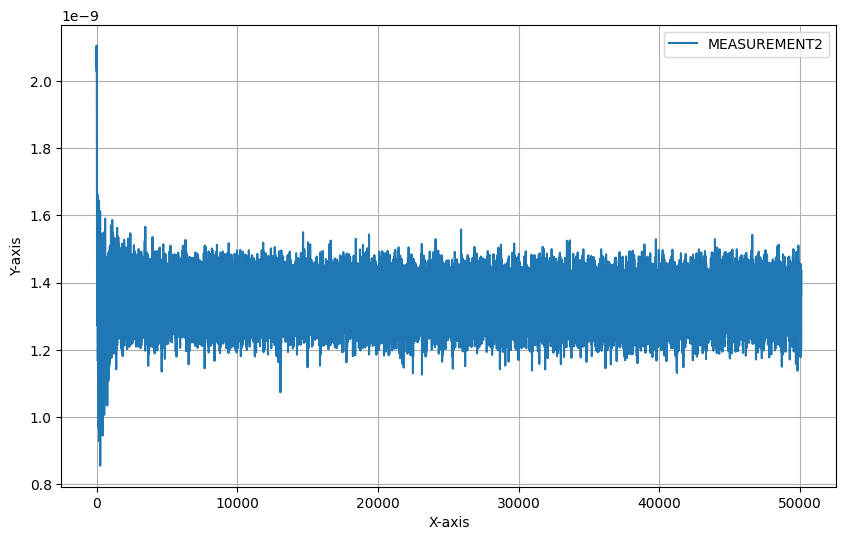

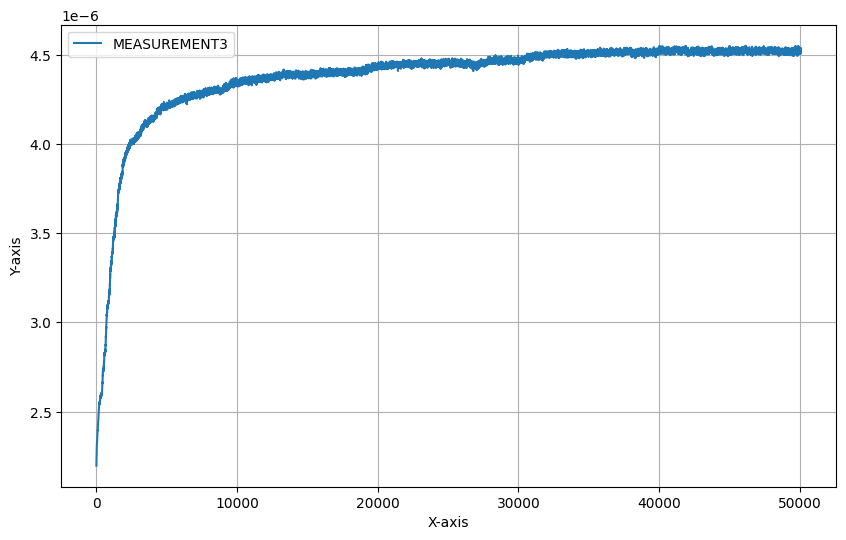

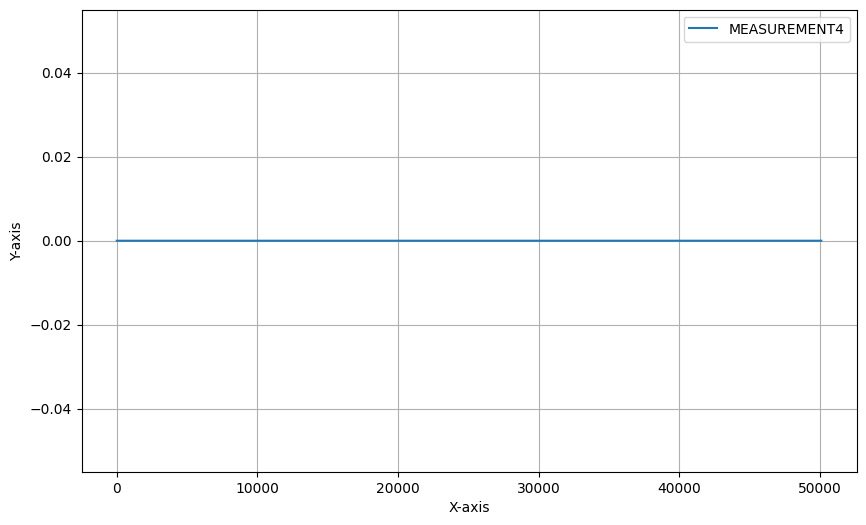

In [14]:

import matplotlib.pyplot as plt

def plot_lists(data, labels=None, title="Plot of Multiple Lists", xlabel="X-axis", ylabel="Y-axis", force=False):
    plt.figure(figsize=(10, 6))
    for i, lst in enumerate(data):
        label = labels[i] if labels and i < len(labels) else f"Series {i+1}"
        plt.plot(lst, label=label)
    if(force): plt.ylim(0,1)
    plt.title("")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()



data = [accuracies]
labels = ["accuracies"]
plot_lists(data, labels, title="Accuracy vs Epoch", xlabel="Epoch", ylabel="Accuracy", force=True)

data = [losses]
labels = ["losses"]
plot_lists(data, labels, title="Loss vs Epoch", xlabel="Epoch", ylabel="Loss")

data = [CLIPPED]
labels = ["CLIPPED"]
plot_lists(data, labels)

data = [ERROR]
labels = ["ERROR"]
plot_lists(data, labels)

data = [MEASUREMENT1]
labels = ["MEASUREMENT1"]
plot_lists(data, labels)

data = [MEASUREMENT2]
labels = ["MEASUREMENT2"]
plot_lists(data, labels)

data = [MEASUREMENT3]
labels = ["MEASUREMENT3"]
plot_lists(data, labels)

data = [MEASUREMENT4]
labels = ["MEASUREMENT4"]
plot_lists(data, labels)


In [ ]:
# model = torch.load("/kaggle/input/mnistclassifier/pytorch/default/1/model_23.pth", weights_only=False)
device = torch.device("cuda")

true_labels = []
predictions = []
with torch.no_grad():
    total_correct = 0
    total_predictions = 0
    for test_imgs, test_labels in test_loader: 
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_preds = model(test_imgs)
        predicted = torch.argmax(test_preds, dim=1)
        total_correct += (predicted == test_labels).sum().item()
        total_predictions += test_labels.size(0)

        true_labels.append(test_labels)
        predictions.append(predicted)
    accuracy = total_correct / total_predictions
print(f"Accuracy: {accuracy}")
true_labels = torch.cat(true_labels)
predictions = torch.cat(predictions)

print(true_labels.shape, predictions.shape)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(labels, predictions, normalize=False):
    cm = confusion_matrix(labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.show()

plot_confusion_matrix(true_labels.cpu().tolist(), predictions.cpu().tolist())